# Tree models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Import data
from Preprocessing import X, Y, n_fold, cv, random_split 
trainX, trainY, testX, testY = random_split(0.8) # set aside 20% of the data for testing

In [4]:
# K-fold cross validation function
def k_fold_cross_validation(MODEL, range_hyperparam:list, hyperparam_name:str, additional_params=None) -> np.array:
    """Performs k-fold cross validation for a given model and hyperparameter / range of hyperparameter"""
    acc = np.zeros(len(range_hyperparam))
    for train_index, val_index in cv.split(trainX): # Loopes over all folds
        X_train, X_val = trainX.iloc[train_index], trainX.iloc[val_index]
        Y_train, Y_val = trainY.iloc[train_index], trainY.iloc[val_index]

        for j,k in enumerate(range_hyperparam): # Loopes over all hyperparameters
            kwargs = {hyperparam_name: k}
            if additional_params is not None:
                kwargs.update(additional_params)
            model = MODEL(**kwargs)
            model.fit(X_train, Y_train)
            acc[j] += model.score(X_val, Y_val)

    acc /= n_fold # average of all average accuracies
    return acc

def best_hyperparam(acc, range_hyperparam, model, hyperparam_name, additional_params=None):
    """Returns the best hyperparameter based on the accuracy"""
    best_hyperparam = range_hyperparam[np.argmax(acc)]
    kwargs = {hyperparam_name: best_hyperparam}
    if additional_params is not None:
        kwargs.update(additional_params)
    BestModel = model(**kwargs)
    BestModel.fit(trainX, trainY)
    
    print('Accuracy with best hyperparameter: ', np.max(acc))
    print('Best hyperparameter: ', best_hyperparam, '\n')   
    print('Confusion matrix:')
    print(pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False))
    pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)

### Classification Tree
1 tree different max depth:

In [5]:
depths = range(1, 150)
acc_gini = k_fold_cross_validation(tree.DecisionTreeClassifier, depths, 'max_depth')
acc_entropy = k_fold_cross_validation(tree.DecisionTreeClassifier, depths, 'max_depth', {'criterion':'entropy'})

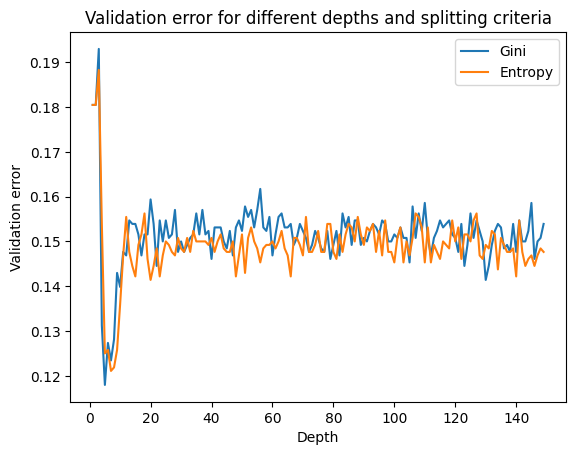

In [6]:
plt.plot(depths, 1- acc_gini, label='Gini')
plt.plot(depths, 1- acc_entropy, label='Entropy')
plt.xlabel('Depth')
plt.ylabel('Validation error')
plt.title('Validation error for different depths and splitting criteria')
plt.legend()
plt.savefig('Figures/SingleTree.png')
plt.show()

In [7]:
print(f'Best depth tree with Gini:\n')
best_hyperparam(acc_gini, depths, tree.DecisionTreeClassifier, 'max_depth')
print('\n\n')
print(f'Best depth tree with Entropy:\n')
best_hyperparam(acc_entropy, depths, tree.DecisionTreeClassifier, 'max_depth', {'criterion':'entropy'})

Best depth tree with Gini:

Accuracy with best hyperparameter:  0.88203125
Best hyperparameter:  5 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                47               10
low_bike_demand                 19              244



Best depth tree with Entropy:

Accuracy with best hyperparameter:  0.87890625
Best hyperparameter:  7 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                49                8
low_bike_demand                 24              239


## Bagging
Test different number of trees:

In [8]:
trees = range(1, 150)
acc_bag = k_fold_cross_validation(BaggingClassifier, trees, 'n_estimators', {'n_jobs': -1})

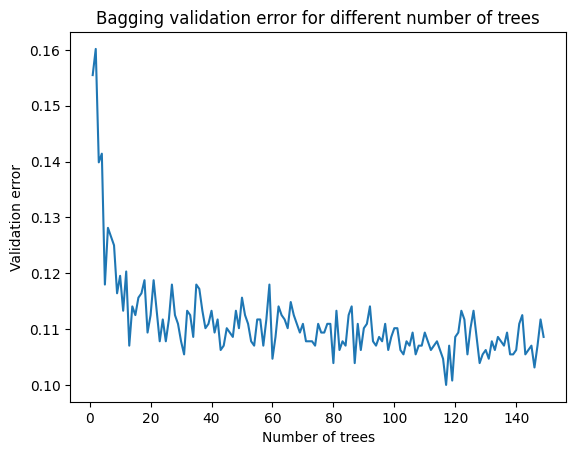

In [9]:
plt.plot(trees, 1 - acc_bag)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging validation error for different number of trees')
plt.savefig('Figures/Bagging.png')
plt.show()

In [10]:
print('Best number of trees for bagging \n')
best_hyperparam(acc_bag, trees, BaggingClassifier, 'n_estimators')

Best number of trees for bagging 

Accuracy with best hyperparameter:  0.9
Best hyperparameter:  117 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                44               13
low_bike_demand                 11              252


## Random Forest
Random forest with different number of trees

In [11]:
trees = range(1, 150)
acc_randf = k_fold_cross_validation(RandomForestClassifier, trees, 'n_estimators', {'random_state': 0, 'n_jobs': -1})

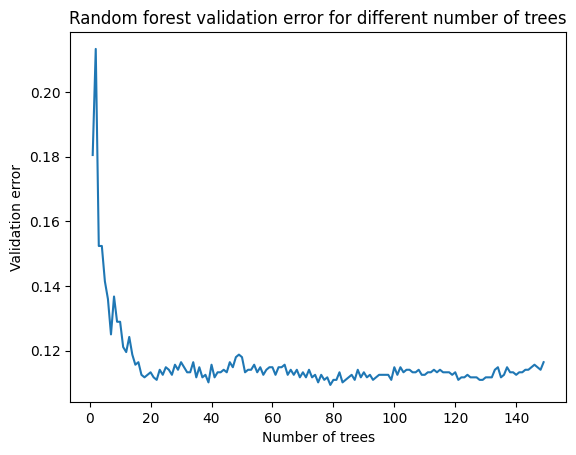

In [12]:
plt.plot(trees, 1 - acc_randf)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Random forest validation error for different number of trees')
plt.savefig('Figures/RandomForest.png')
plt.show()

In [13]:
print('Best number of trees for random forest \n')
best_hyperparam(acc_randf, trees, RandomForestClassifier, 'n_estimators')

Best number of trees for random forest 

Accuracy with best hyperparameter:  0.890625
Best hyperparameter:  79 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                33               24
low_bike_demand                  9              254


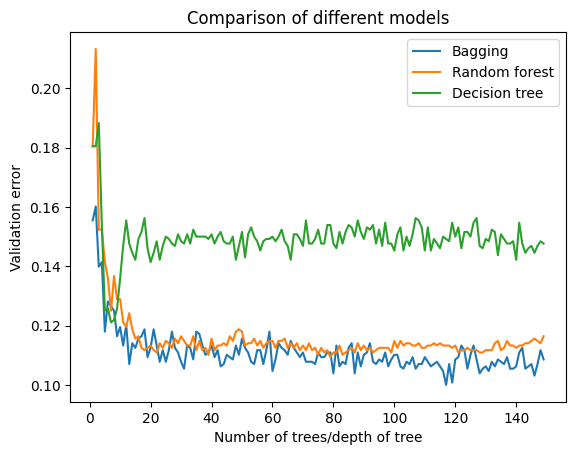

In [14]:
# Compare all models
plt.plot(trees, 1 - acc_bag, label='Bagging')
plt.plot(trees, 1 - acc_randf, label='Random forest')
plt.plot(depths, 1 - acc_entropy, label='Decision tree')

plt.xlabel('Number of trees/depth of tree')
plt.ylabel('Validation error')
plt.title('Comparison of different models')
plt.legend()
plt.savefig('Figures/AllTrees.png')
plt.show()

See that the bagging and random forest models perform equal. The decision tree seem to have optimal performance if we use entropy split. Use this tree as the estimators for bagging and random forest:

In [ ]:
trees2 = range(1, 150)
bestTree = tree.DecisionTreeClassifier(criterion='entropy')

acc_bag2 = k_fold_cross_validation(BaggingClassifier, trees2, 'n_estimators', {'estimator': bestTree, 'n_jobs': -1})
acc_randf2 = k_fold_cross_validation(RandomForestClassifier, trees2, 'n_estimators',{'criterion':'entropy', 'n_jobs': -1})

In [ ]:
plt.plot(trees, 1 - acc_bag, label='Bagging')
plt.plot(trees, 1 - acc_randf, label='Random forest')
plt.plot(trees2, 1 - acc_bag2, label='Bagging with best tree')
plt.plot(trees2, 1 - acc_randf2, label='Random forest with best tree')

plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging and random forest with & without best tree')
plt.xlim(0,150)
plt.ylim(0.085, 0.15)
plt.legend()
plt.savefig('Figures/BestTree.png')
plt.show()

In [ ]:
print('Best number of trees for bagging with best tree \n')
best_hyperparam(acc_bag2, trees2, BaggingClassifier, 'n_estimators', {'estimator': bestTree})
print('\n-----------------------------------------------------\n')
print('Best number of trees for random forest with best tree \n')
best_hyperparam(acc_randf2, trees2, RandomForestClassifier, 'n_estimators' , {'criterion':'entropy'})

The best tree seems to improve results a tiny bit!

## Final model
Final best model is the Bagging classifier with entropy splitting and approximately 100 trees.

In [ ]:
finalModel = BaggingClassifier(n_estimators=100, estimator=bestTree, random_state=0)
finalModel.fit(trainX, trainY)
print('Accuracy of final bagging model: ', finalModel.score(testX, testY))
print('Confusion matrix:')
pd.crosstab(testY, finalModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)